# 3W dataset's General Presentation

This is a general presentation of the 3W dataset, to the best of its authors' knowledge, the first realistic and public dataset with rare undesirable real events in oil wells that can be readily used as a benchmark dataset for development of machine learning techniques related to inherent difficulties of actual data.

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook presents the 3W dataset in a general way. For this, some tables, graphs, and statistics are presented.

# 2. Imports and Configurations

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import pickle
import graphviz
from copy import deepcopy

from river import stream, feature_extraction as fx, compose, stats, preprocessing, tree, metrics, evaluate
from river import linear_model, optim, drift, anomaly, utils, ensemble, multiclass

import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import river
river.__version__

'0.12.1'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [3]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":

                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                        
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True):
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [4]:
if pathlib.Path('dset_river.pkl').exists():
  with open('dset_river.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_river.pkl', 'wb') as f:
      pickle.dump(dset, f)

In [20]:
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[[0,1,2,3,4,5,6,7,8,101,102,103,104,105,106,107,108]]

train_df, test_df = dset.split(real=True, simul=True, drawn=True, test_size=0.1, val_size=0, sample_n=None)

Instances Train: 1782  Test: 199


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

More information about these variables can be obtained from the following publicly available documents:

* ***Option in Portuguese***: R.E.V. Vargas. Base de dados e benchmarks para prognóstico de anomalias em sistemas de elevação de petróleo. Universidade Federal do Espírito Santo. Doctoral thesis. 2019. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/doctoral_thesis_ricardo_vargas.pdf.
* ***Option in English***: B.G. Carvalho. Evaluating machine learning techniques for detection of flow instability events in offshore oil wells. Universidade Federal do Espírito Santo. Master's degree dissertation. 2021. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/master_degree_dissertation_bruno_carvalho.pdf.

In [6]:
class CustomGen():
    
    def __init__(self, dset, flist, target, scaleb=False, out_time=False, ifileb=False):
        self.dset = dset
        self.flist = flist
        self.target = target
        self.scaleb = scaleb
        self.out_time = out_time
        self.ifileb = ifileb
        self.nfiles = len(dset.index)
        return
    
    def iter(self, max_n=None):
        n = 0
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])


            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)
#####
            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = None
            
#####
            
            if self.scaleb:
                np.seterr(divide='ignore', invalid='ignore')
                dfd = self.scale(ds[self.flist]).to_dict(orient='records')
                np.seterr(divide='warn', invalid='warn')
            else:
                dfd = ds[self.flist].to_dict(orient='records')
            for i, x in enumerate(dfd):
                #assert isinstance(df.iloc[i][self.target], np.int32), 'class not an integer!'
                result = []
                if self.ifileb:
                    result.append(ifile)
                if self.out_time:
                    result.append(ds.index[i])
                yield result + [x, ds.iloc[i][self.target]]
                n += 1
                if max_n is not None and n > max_n:
                    break
            if max_n is not None and n > max_n:
                break

        return
    
    def scale(self, df):
        scale = StandardScaler()
        return pd.DataFrame(scale.fit_transform(df[self.flist]), columns=df[self.flist].columns, index=df.index)

    def plot(self, ifile):
        
        ds = pd.read_csv(self.dset['path'][ifile], parse_dates=["timestamp"])
        fig, axs = plt.subplots(nrows=len(self.flist)+1, figsize=(10, 12), sharex=True)
        
        fig.suptitle(self.dset['path'][ifile])

        for i, vs in enumerate(self.flist):
            axs[i].plot(ds.timestamp[::60], ds[vs][::60])
            axs[i].set_ylabel(vs)
        
        id = np.argsort(ds[self.target])
        t = [ds.timestamp[i] for i in id][::60]
        y = [str(ds[self.target][i]) for i in id][::60]
        
        axs[i+1].scatter(t, y, marker='.')
        
        axs[i+1].set_ylabel(self.target)
        
        axs[i+1].set_xlabel('Date')
        
        for ax in axs:
            ax.grid(visible=True)

        plt.show()    


In [7]:
gen = CustomGen(dset.all, flist, 'class', scaleb=True, out_time=True, ifileb=True)
n = 0
for i, time, x, t in gen.iter():
    if i == 3:
        print(i, time, x, t)
        n += 1
        if n > 3:
            break

3 2017-02-01 17:03:00 {'P-PDG': 0.0, 'P-TPT': 1.6268455497858516, 'T-TPT': 0.6107019574398811, 'P-MON-CKP': -2.3605850221075504, 'T-JUS-CKP': -2.4912555180557248, 'P-JUS-CKGL': -1.7252071303308338, 'T-JUS-CKGL': nan, 'QGL': 0.0} 0
3 2017-02-01 17:04:00 {'P-PDG': 0.0, 'P-TPT': 1.5384827559763783, 'T-TPT': 0.8289820795111031, 'P-MON-CKP': 0.08381503692514768, 'T-JUS-CKP': -0.5982713149552483, 'P-JUS-CKGL': -1.7147145050257622, 'T-JUS-CKGL': nan, 'QGL': 0.0} 0
3 2017-02-01 17:05:00 {'P-PDG': 0.0, 'P-TPT': 1.441203583466008, 'T-TPT': 1.0694089511284939, 'P-MON-CKP': 1.0490451239608052, 'T-JUS-CKP': 1.0781421342886914, 'P-JUS-CKGL': -1.7029976967827822, 'T-JUS-CKGL': nan, 'QGL': 0.0} 0
3 2017-02-01 17:06:00 {'P-PDG': 0.0, 'P-TPT': 1.3439226839429559, 'T-TPT': 1.308767258872177, 'P-MON-CKP': -0.9890194135509329, 'T-JUS-CKP': 0.9717959214078659, 'P-JUS-CKGL': -1.6914719234560964, 'T-JUS-CKGL': nan, 'QGL': 0.0} 0


In [8]:
#gen.plot(100)

In [14]:
class river_model():
    
    def __init__(self, train_df, test_df, fdict, model, start_delay, flist, target):
        
        self.train_df = train_df
        self.test_df = test_df
        self.fdict = deepcopy(fdict)
        self.model = model.clone()
        self.start_delay = start_delay
        self.flist = flist
        self.target = target
        return
    
    def learn(self):
        
        gen = CustomGen(self.train_df, self.flist, self.target, ifileb=True)
        
        lastfile = -1
        flag = True
        for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
            if ifile != lastfile:
                print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
                scaler = preprocessing.StandardScaler()
                fd = deepcopy(self.fdict)
                lastfile = ifile
                j = 0
            x = {k: v for k, v in x.items() if v is not None}
            x = scaler.learn_one(x).transform_one(x)
            xd = {}
            for f in x.keys():
                for fu in fd.keys():
                    tmp = fd[fu].update(x[f]).get()
                    if isinstance(tmp, dict):
                        xd = xd | compose.Prefixer(f+'_').transform_one(tmp)
                    else:
                        xd[f+'_'+fu] = fd[fu].update(x[f]).get()
            if j >= self.start_delay:
                if flag:
                    print('\n', xd)
                    flag = False
                self.model.learn_one(xd, y)
            j += 1
        print('\n')
        return
        
    def score(self):
        
        gen = CustomGen(self.test_df, self.flist, self.target, ifileb=True)
        
        report = metrics.ClassificationReport()
        
        lastfile = -1
        for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
            if ifile != lastfile:
                print('\rfiles scored ', ifile+1, '/', gen.nfiles, end='')
                scaler = preprocessing.StandardScaler()
                fd = deepcopy(self.fdict)
                lastfile = ifile
                j = 0
            x = {k: v for k, v in x.items() if v is not None}
            x = scaler.learn_one(x).transform_one(x)
            xd = {}
            for f in x.keys():
                for fu in fd.keys():
                    tmp = fd[fu].update(x[f]).get()
                    if isinstance(tmp, dict):
                        xd = xd | compose.Prefixer(f+'_').transform_one(tmp)
                    else:
                        xd[f+'_'+fu] = fd[fu].update(x[f]).get()
            if j >= self.start_delay:
                y_pred = self.model.predict_one(xd)
                report = report.update(y, y_pred)
                
            j += 1
        print('\n\n', report)
        return

In [10]:
from collections import deque

from river import stats

class LaggedSet(stats.base.Univariate):
    """Computes a streaming lagged window.

    """

    def __init__(self, lag: int, name='lag', every=1):
        self.lag = lag
        self.every = every
        self._feature_name = name
        self.q = deque(lag*[0], maxlen=lag)
        self.keys=[self._feature_name+'_'+str(i) for i in range(0, lag, every)]
        return
    
    def update(self, x):
        self.q.appendleft(x)
        return self

    def get(self):
        return dict(zip(self.keys, [self.q[i] for i in range(0, self.lag, self.every)]))

    def __str__(self):
        return self._feature_name


In [21]:
window_size = 15
fd = {}
fd['lagged'+'_'+str(window_size)] = LaggedSet(window_size, every=2)
fd['rmean'+'_'+str(window_size)] = utils.Rolling(stats.Mean(), window_size=window_size)
fd['rSEM'+'_'+str(window_size)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
fd['rQ25'+'_'+str(window_size)] = stats.RollingQuantile(q=0.25, window_size=window_size)
fd['rQ75'+'_'+str(window_size)] = stats.RollingQuantile(q=0.75, window_size=window_size)
fd['rMax'+'_'+str(window_size)] = stats.RollingMax(window_size=window_size)
fd['rMin'+'_'+str(window_size)] = stats.RollingMin(window_size=window_size)


In [22]:
%%time

model = tree.HoeffdingTreeClassifier(grace_period=100, max_depth=60, remove_poor_attrs=True)
#model = multiclass.OutputCodeClassifier(
#        classifier=tree.HoeffdingTreeClassifier(grace_period=100, max_depth=60, remove_poor_attrs=True), 
#        #classifier=linear_model.LogisticRegression(),
#        code_size=10,
#        seed=200560)

rmHTC = river_model(train_df, test_df, fd, model, window_size, flist, 'class')

rmHTC.learn()

rmHTC.score()

files learned  1 / 1782
 {'P-PDG_lag_0': 0.0, 'P-PDG_lag_2': -1.623495801444409, 'P-PDG_lag_4': 0.029651562542114346, 'P-PDG_lag_6': -1.7531628403525044, 'P-PDG_lag_8': 0.0, 'P-PDG_lag_10': 0.0, 'P-PDG_lag_12': 1.4426954134705332, 'P-PDG_lag_14': 0.0, 'P-PDG_rmean_15': -0.333427148136409, 'P-PDG_rSEM_15': 0.23078798483714347, 'P-PDG_rQ25_15': -0.8117479007222045, 'P-PDG_rQ75_15': 0.014825781271057173, 'P-PDG_rMax_15': 0.846303468231735, 'P-PDG_rMin_15': -1.7531628403525044, 'P-TPT_lag_0': -1.5372591859281344, 'P-TPT_lag_2': 0.0, 'P-TPT_lag_4': 0.0, 'P-TPT_lag_6': 0.846303468231735, 'P-TPT_lag_8': 0.0, 'P-TPT_lag_10': -1.6161744003524983, 'P-TPT_lag_12': -1.4589220420896085, 'P-TPT_lag_14': 0.44108188398112874, 'P-TPT_rmean_15': -0.4215175169033266, 'P-TPT_rSEM_15': 0.2374512589986406, 'P-TPT_rQ25_15': -1.5372591859281344, 'P-TPT_rQ75_15': 0.014825781271057173, 'P-TPT_rMax_15': 0.846303468231735, 'P-TPT_rMin_15': -1.7531628403525044, 'T-TPT_lag_0': 0.2886200563763192, 'T-TPT_lag_2': 0.0


(dot.exe:5368): Pango-WARNING **: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


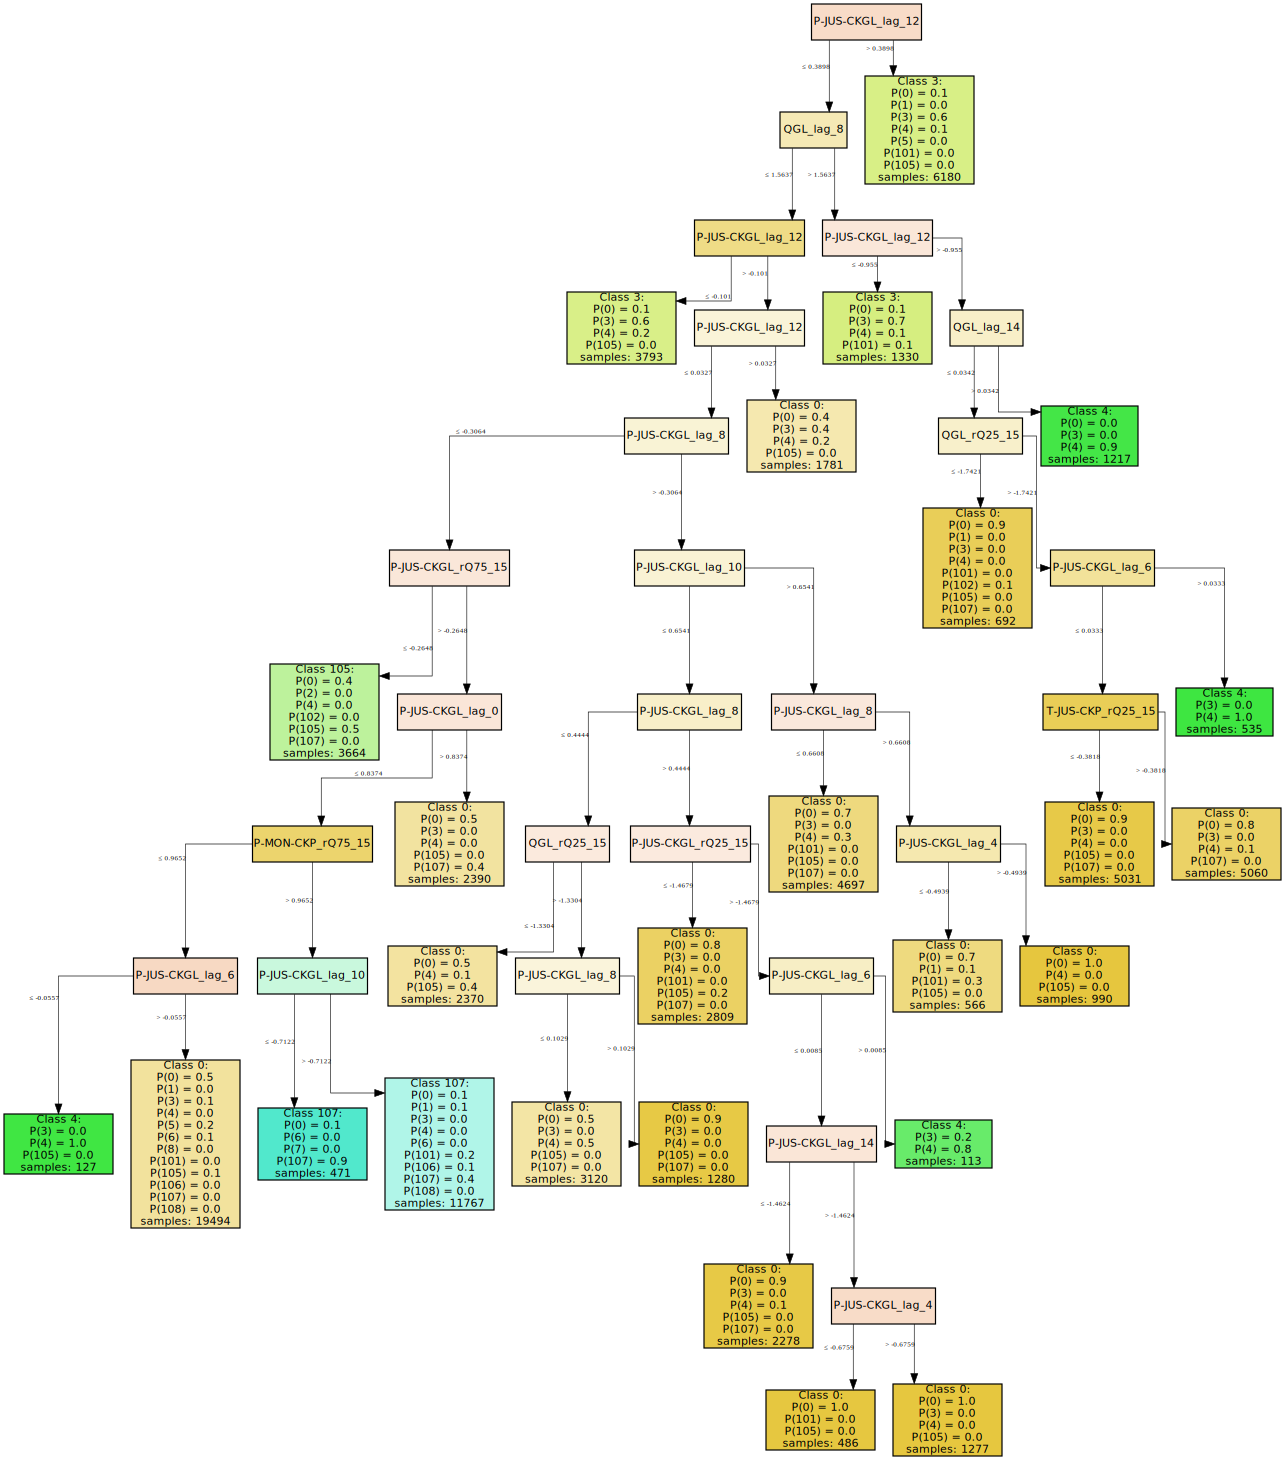

In [23]:
#model.code_book
rmHTC.model.draw()

with open('HoeffdingTreeClassifier.pkl', 'wb') as outp:
    pickle.dump(model, outp)

with open('HoeffdingTreeClassifier.pkl', 'rb') as inp:
    model0 = pickle.load(inp)

## Drift test

## Anomaly detector

In [ ]:
df = tk.load_instance(real_instances[real_instances.label==2].iloc[0])
df_clean = df[flist+['class']].dropna()

f = 'T-TPT'

detector = anomaly.GaussianScorer(window_size=None, grace_period=300)

anomalies = []

for i, val in enumerate(df_clean[f]):
    anomalies.append(detector.score_one(None, val))
    detector = detector.learn_one(None, val)
anomalies = pd.Series(anomalies, index=df_clean.index)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 6), sharex=True)
ax1.grid
ax2.grid
ax3.grid
ax1.plot(df_clean[f], label='Stream', color='blue')
ax2.plot(anomalies, label='Anomalies prob', color='red')
ax2.axhline(0.95, color='green')
ax3.plot(df_clean['class'], label='class', color='black')

plt.tight_layout
plt.show()